# G-Code parsing

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from mpl_toolkits import mplot3d

import meshcut
from stl import mesh
import numpy.linalg as la

#--- for gcode parser
from pygcode import *
from pygcode import Line
from pygcode import Machine, GCodeRapidMove

%matplotlib inline

### MatterSlice 1.0, G-Code sample

```G92 E0 ; reset the expected extruder position
M82 ; use absolute distance for extrusion
; Layer count: 175
; Layer Change GCode
; LAYER:0
M400
M107
G1 X0.01 Y0 Z0.4 F3000
G1 X-5.26 Y-6.14 Z0.424
G1 X-5.61 Y-6.49 Z0.426
G1 X-5.89 Y-6.21 Z0.432
; TYPE:WALL-OUTER
G1  F1800
G1 X-9.92 Y-10.28 Z0.455 E0.36 F360
G1 X-9.98 Y-11.04 Z0.45 E0.408
G1 X-11.38 Y-12.53 Z0.457 E0.537
G1 X-11.16 Y-14.11 Z0.442 E0.637
G1 X-9.55 Y-15.55 Z0.408 E0.772
G1 X-5.28 Y-17.24 Z0.335 E1.062
G1 X-5.02 Y-17.13 Z0.332 E1.079
G1 X-4.71 Y-17.54 Z0.325 E1.111
G1 X-1.7 Y-20.77 Z0.257 E1.389
G1 X2.04 Y-20.05 Z0.211 E1.628
G1 X3.02 Y-19.58 Z0.201 E1.696
G1 X4.62 Y-11.52 Z0.244 E2.213
G1 X6.29 Y-10.1 Z0.232 E2.351```

### Parse the whole gcode file

In [2]:
# gcode info:

# layer number

# TYPE:WALL-OUTER          -- 1
# TYPE:WALL-INNER          -- 2
# TYPE:FILL                -- 3
# TYPE:SUPPORT             -- 4
# TYPE:SUPPORT-INTERFACE   -- 5


word_bank  = []
layer_bank = [] # just a number of layer
type_bank = []
line_bank = []
parsed_Num_of_layers = 0
gcode_type = 0

#with open('fox/70mm_fox.gcode', 'r') as fh:
with open('stl_gcode/70mm_low_poly_fox_MatterControl.gcode', 'r') as fh:
    for line_text in fh.readlines():
        line = Line(line_text) # all lines in file
        # print(line)
        w = line.block.words # splits blocks into XYZEF, omits comments
        # print(w)
        if(np.shape(w)[0] == 0): # if line is empty, i.e. comment line -> then skip it
            pass
        else:
            word_bank.append(w) # <Word: G01>, <Word: X15.03>, <Word: Y9.56>, <Word: Z0.269>, ...
            # print(word_bank) # does not process comments
            layer_bank.append(parsed_Num_of_layers)
            type_bank.append(gcode_type)
            line_bank.append(line_text)
            # np.shape(layer_bank) = np.shape(word_bank) = np.shape(line_bank) = len(layer_bank)
            #print(layer_bank)
            # line_bank[0] = 'G21 ; set units to millimeters\n'
            # all lines in file
        if line.comment:
            #print(line.comment)
            if (line.comment.text[0:6] == "LAYER:"):
                parsed_Num_of_layers = parsed_Num_of_layers + 1
                gcode_type = 0
            if line.comment:
                if (line.comment.text[0:15] == "TYPE:WALL-OUTER"):
                    #print("TYPE:WALL-OUTER")
                    gcode_type = 1
                if (line.comment.text[0:15] == "TYPE:WALL-INNER"):
                    #print("TYPE:WALL-INNER")
                    gcode_type = 2
                if (line.comment.text[0:9] == "TYPE:FILL"):
                    #print("TYPE:FILL")
                    gcode_type = 3
                if (line.comment.text[0:12] == "TYPE:SUPPORT"):
                    #print("TYPE:SUPPORT")
                    gcode_type = 4
                if (line.comment.text[0:22] == "TYPE:SUPPORT-INTERFACE"):
                    #print("TYPE:SUPPORT-INTERFACE")
                    gcode_type = 5
                
print(parsed_Num_of_layers)

175


### Process a single layer

In [8]:
for k in [33-2]: # layers
    command_bank = []
    line_command_bank = []
    gcode_line_number = 0
    
    X_active_bank = []
    Y_active_bank = []
    Z_active_bank = []
    G_active_bank = []
    E_active_bank = []
    F_active_bank = []

    idx = []
    
    X_active_default = []; X_active_wall_outer = []; X_active_wall_inner = []
    Y_active_default = []; Y_active_wall_outer = []; Y_active_wall_inner = []
    Z_active_default = []; Z_active_wall_outer = []; Z_active_wall_inner = []
    G_active_default = []; G_active_wall_outer = []; G_active_wall_inner = []
    E_active_default = []; E_active_wall_outer = []; E_active_wall_inner = []
    F_active_default = []; F_active_wall_outer = []; F_active_wall_inner = []

    X_active_fill = []; X_active_support = []; X_active_support_interface = []
    Y_active_fill = []; Y_active_support = []; Y_active_support_interface = []
    Z_active_fill = []; Z_active_support = []; Z_active_support_interface = []
    G_active_fill = []; G_active_support = []; G_active_support_interface = []
    E_active_fill = []; E_active_support = []; E_active_support_interface = []
    F_active_fill = []; F_active_support = []; F_active_support_interface = []
    
    for i in range(len(layer_bank)): # for each line in file
        if (layer_bank[i] == k):
            idx.append(i)
            line_command_bank.append(line_bank[i])
            # line_command_bank = all gcode for the specific layer without comments
            for j in range(len(word_bank[i])):
                command_bank.append(str(word_bank[i][j]))
                if (str(word_bank[i][j])[:1] == 'G'):
                    G_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'X'):
                    X_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'Y'):
                    Y_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'Z'):
                    Z_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'E'):
                    E_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'F'):
                    F_active_bank.append(float(str(word_bank[i][j])[1:]))

    for m in range(len(X_active_bank)):
        if(type_bank[np.min(idx)+m] == 0):
            X_active_default.append(X_active_bank[m])
            Y_active_default.append(Y_active_bank[m])
            Z_active_default.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 1):
            X_active_wall_outer.append(X_active_bank[m])
            Y_active_wall_outer.append(Y_active_bank[m])
            Z_active_wall_outer.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 2):
            X_active_wall_inner.append(X_active_bank[m])
            Y_active_wall_inner.append(Y_active_bank[m])
            Z_active_wall_inner.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 3):
            X_active_fill.append(X_active_bank[m])
            Y_active_fill.append(Y_active_bank[m])
            Z_active_fill.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 4):
            X_active_support.append(X_active_bank[m])
            Y_active_support.append(Y_active_bank[m])
            Z_active_support.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 5):
            X_active_support_interface.append(X_active_bank[m])
            Y_active_support_interface.append(Y_active_bank[m])
            Z_active_support_interface.append(Z_active_bank[m])

            
    G_default = np.zeros((np.shape(X_active_default)[0],4),dtype=np.float32)
    G_wall_outer = np.zeros((np.shape(X_active_wall_outer)[0],4),dtype=np.float32)
    G_wall_inner = np.zeros((np.shape(X_active_wall_inner)[0],4),dtype=np.float32)
    G_fill = np.zeros((np.shape(X_active_fill)[0],4),dtype=np.float32)
    G_support = np.zeros((np.shape(X_active_support)[0],4),dtype=np.float32)
    G_support_interface = np.zeros((np.shape(X_active_support_interface)[0],4),dtype=np.float32)

    G_default[:,0] = X_active_default
    G_default[:,1] = Y_active_default
    G_default[:,2] = Z_active_default
    G_default[:,3] = np.ones((1,np.shape(X_active_default)[0]),dtype=np.float32)

    G_wall_outer[:,0] = X_active_wall_outer
    G_wall_outer[:,1] = Y_active_wall_outer
    G_wall_outer[:,2] = Z_active_wall_outer
    G_wall_outer[:,3] = np.ones((1,np.shape(X_active_wall_outer)[0]),dtype=np.float32)

    G_wall_inner[:,0] = X_active_wall_inner
    G_wall_inner[:,1] = Y_active_wall_inner
    G_wall_inner[:,2] = Z_active_wall_inner
    G_wall_inner[:,3] = np.ones((1,np.shape(X_active_wall_inner)[0]),dtype=np.float32)

    G_fill[:,0] = X_active_fill
    G_fill[:,1] = Y_active_fill
    G_fill[:,2] = Z_active_fill
    G_fill[:,3] = np.ones((1,np.shape(X_active_fill)[0]),dtype=np.float32)

    G_support[:,0] = X_active_support
    G_support[:,1] = Y_active_support
    G_support[:,2] = Z_active_support
    G_support[:,3] = np.ones((1,np.shape(X_active_support)[0]),dtype=np.float32)

    G_support_interface[:,0] = X_active_support_interface
    G_support_interface[:,1] = Y_active_support_interface
    G_support_interface[:,2] = Z_active_support_interface
    G_support_interface[:,3] = np.ones((1,np.shape(X_active_support_interface)[0]),dtype=np.float32)

### Draw the layer

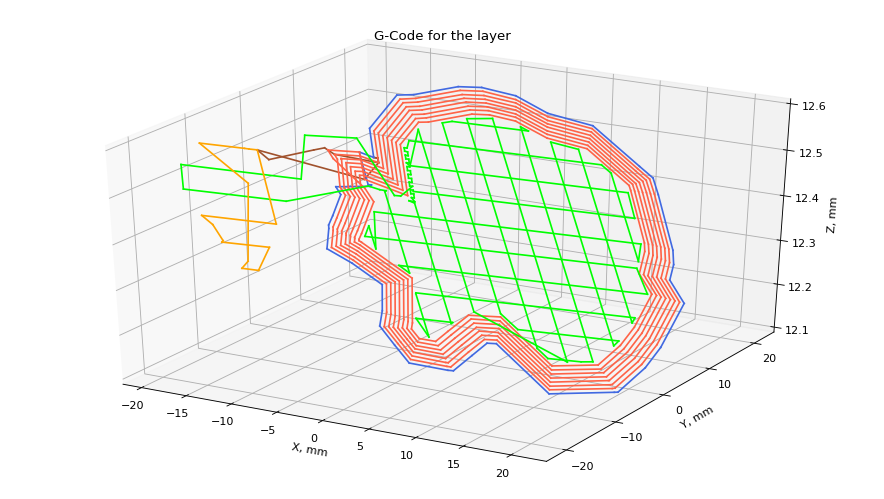

In [9]:
fig = plt.figure(figsize=(14, 8), dpi=80)
ax = fig.add_subplot(111, projection='3d')
for i in range(len(X_active_default)):
    ax.plot([X_active_default[i],X_active_default[i-1]],
        [Y_active_default[i],Y_active_default[i-1]],
        [Z_active_default[i],Z_active_default[i-1]],color='sienna')

for i in range(len(X_active_wall_outer)):
    ax.plot([X_active_wall_outer[i],X_active_wall_outer[i-1]],
        [Y_active_wall_outer[i],Y_active_wall_outer[i-1]],
        [Z_active_wall_outer[i],Z_active_wall_outer[i-1]],color='royalblue')

for i in range(len(X_active_wall_inner)):
    ax.plot([X_active_wall_inner[i],X_active_wall_inner[i-1]],
        [Y_active_wall_inner[i],Y_active_wall_inner[i-1]],
        [Z_active_wall_inner[i],Z_active_wall_inner[i-1]],color='tomato')

for i in range(len(X_active_fill)):
    ax.plot([X_active_fill[i],X_active_fill[i-1]],
        [Y_active_fill[i],Y_active_fill[i-1]],
        [Z_active_fill[i],Z_active_fill[i-1]],color='lime')

for i in range(len(X_active_support)):
    ax.plot([X_active_support[i],X_active_support[i-1]],
        [Y_active_support[i],Y_active_support[i-1]],
        [Z_active_support[i],Z_active_support[i-1]],color='orange')

for i in range(len(X_active_support_interface)):
    ax.plot([X_active_support_interface[i],X_active_support_interface[i-1]],
        [Y_active_support_interface[i],Y_active_support_interface[i-1]],
        [Z_active_support_interface[i],Z_active_support_interface[i-1]],color='cyan')
ax.set_xlabel('X, mm')
ax.set_ylabel('Y, mm')
ax.set_zlabel('Z, mm')
ax.set_title('G-Code for the layer')
plt.show()

### MatterSlice 2.20.10, G-Code sample

```G90 ; use absolute coordinates
G92 E0 ; reset the expected extruder position
M82 ; use absolute distance for extrusion
; Layer count: 230
; Layer Change GCode
; LAYER:0
; LAYER_HEIGHT:0.2
; TYPE:FILL
M400
M107
G0 X149 Y124 Z0.8 F10800
; TYPE:SKIRT
G0 Z0.2
G0 F2100
G1 X111 E1.201 F2400
G1 Y86 E2.401
G1 X149 E3.602
G1 Y124 E4.803
G0 X148.6 Y123.6 F10800
G1 X111.4 E5.978 F2400
G1 Y86.4 E7.154
G1 X148.6 E8.329
G1 Y123.6 E9.504
G0 X148.2 Y123.2 F10800
G1 X111.8 E10.655 F2400
G1 Y86.8 E11.805
G1 X148.2 E12.955
G1 Y123.2 E14.105
G0 X147.8 Y122.8 F10800
G1 X112.2 E15.23 F2400
G1 Y87.2 E16.355
G1 X147.8 E17.48
G1 Y122.8 E18.604
G0 X147.4 Y122.4 F10800
G1 X112.6 E19.704 F2400
G1 Y87.6 E20.804
G1 X147.4 E21.903
G1 Y122.4 E23.003
G0 X144.8 Y119.8 F10800```

### Parse the whole gcode file

In [20]:
# gcode info:

# layer number

# TYPE:WALL-OUTER          -- 1
# TYPE:WALL-INNER          -- 2
# TYPE:FILL                -- 3
# TYPE:SUPPORT             -- 4
# TYPE:SUPPORT-INTERFACE   -- 5


word_bank  = []
layer_bank = [] # just a number of layer
type_bank = []
line_bank = []
parsed_Num_of_layers = 0
gcode_type = 0

#with open('fox/70mm_fox.gcode', 'r') as fh:
with open('stl_gcode/MatterSlice_2.20.10_truncated,.gcode', 'r') as fh:
    for line_text in fh.readlines():
        line = Line(line_text) # all lines in file
        # print(line)
        # line - G01 X144 E234.523
        w = line.block.words # splits blocks into XYZEF, omits comments
        # print(w)
        # w - [<Word: G01>, <Word: X120.67>, <Word: E233.786>, <Word: F2700>]
        if(np.shape(w)[0] == 0): # if line is empty, i.e. comment line -> then skip it
            pass
        else:
            word_bank.append(w) # <Word: G01>, <Word: X15.03>, <Word: Y9.56>, <Word: Z0.269>, ...
            # print(word_bank) # does not process comments
            layer_bank.append(parsed_Num_of_layers)
            type_bank.append(gcode_type)
            line_bank.append(line_text)
            # np.shape(layer_bank) = np.shape(word_bank) = np.shape(line_bank) = len(layer_bank)
            # print(layer_bank)
            # line_bank[0] = 'G21 ; set units to millimeters\n'
            # all lines in file
        if line.comment:
            # print(line.comment)
            if (line.comment.text[0:6] == "LAYER:"):
                parsed_Num_of_layers = parsed_Num_of_layers + 1
                gcode_type = 0
            if line.comment:
                if (line.comment.text[0:15] == "TYPE:WALL-OUTER"):
                    #print("TYPE:WALL-OUTER")
                    gcode_type = 1
                if (line.comment.text[0:15] == "TYPE:WALL-INNER"):
                    #print("TYPE:WALL-INNER")
                    gcode_type = 2
                if (line.comment.text[0:9] == "TYPE:FILL"):
                    #print("TYPE:FILL")
                    gcode_type = 3
                if (line.comment.text[0:12] == "TYPE:SUPPORT"):
                    #print("TYPE:SUPPORT")
                    gcode_type = 4
                if (line.comment.text[0:22] == "TYPE:SUPPORT-INTERFACE"):
                    #print("TYPE:SUPPORT-INTERFACE")
                    gcode_type = 5
                
print(parsed_Num_of_layers)

4


In [22]:
len(layer_bank)

974

In [19]:
for k in [2]: # layers
    command_bank = []
    line_command_bank = []
    gcode_line_number = 0
    
    X_active_bank = []
    Y_active_bank = []
    Z_active_bank = []
    G_active_bank = []
    E_active_bank = []
    F_active_bank = []

    idx = []
    
    X_active_default = []; X_active_wall_outer = []; X_active_wall_inner = []
    Y_active_default = []; Y_active_wall_outer = []; Y_active_wall_inner = []
    Z_active_default = []; Z_active_wall_outer = []; Z_active_wall_inner = []
    G_active_default = []; G_active_wall_outer = []; G_active_wall_inner = []
    E_active_default = []; E_active_wall_outer = []; E_active_wall_inner = []
    F_active_default = []; F_active_wall_outer = []; F_active_wall_inner = []

    X_active_fill = []; X_active_support = []; X_active_support_interface = []
    Y_active_fill = []; Y_active_support = []; Y_active_support_interface = []
    Z_active_fill = []; Z_active_support = []; Z_active_support_interface = []
    G_active_fill = []; G_active_support = []; G_active_support_interface = []
    E_active_fill = []; E_active_support = []; E_active_support_interface = []
    F_active_fill = []; F_active_support = []; F_active_support_interface = []
    
    for i in range(len(layer_bank)): # for each line in file
        if (layer_bank[i] == k):
            idx.append(i)
            line_command_bank.append(line_bank[i])
            # line_command_bank = all gcode for the specific layer without comments
            for j in range(len(word_bank[i])):
                command_bank.append(str(word_bank[i][j]))
                if (str(word_bank[i][j])[:1] == 'G'):
                    G_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'X'):
                    X_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'Y'):
                    Y_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'Z'):
                    Z_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'E'):
                    E_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'F'):
                    F_active_bank.append(float(str(word_bank[i][j])[1:]))

    for m in range(len(X_active_bank)):
        if(type_bank[np.min(idx)+m] == 0):
            X_active_default.append(X_active_bank[m])
            Y_active_default.append(Y_active_bank[m])
            Z_active_default.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 1):
            X_active_wall_outer.append(X_active_bank[m])
            Y_active_wall_outer.append(Y_active_bank[m])
            Z_active_wall_outer.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 2):
            X_active_wall_inner.append(X_active_bank[m])
            Y_active_wall_inner.append(Y_active_bank[m])
            Z_active_wall_inner.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 3):
            X_active_fill.append(X_active_bank[m])
            Y_active_fill.append(Y_active_bank[m])
            Z_active_fill.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 4):
            X_active_support.append(X_active_bank[m])
            Y_active_support.append(Y_active_bank[m])
            Z_active_support.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 5):
            X_active_support_interface.append(X_active_bank[m])
            Y_active_support_interface.append(Y_active_bank[m])
            Z_active_support_interface.append(Z_active_bank[m])

            
    G_default = np.zeros((np.shape(X_active_default)[0],4),dtype=np.float32)
    G_wall_outer = np.zeros((np.shape(X_active_wall_outer)[0],4),dtype=np.float32)
    G_wall_inner = np.zeros((np.shape(X_active_wall_inner)[0],4),dtype=np.float32)
    G_fill = np.zeros((np.shape(X_active_fill)[0],4),dtype=np.float32)
    G_support = np.zeros((np.shape(X_active_support)[0],4),dtype=np.float32)
    G_support_interface = np.zeros((np.shape(X_active_support_interface)[0],4),dtype=np.float32)

    G_default[:,0] = X_active_default
    G_default[:,1] = Y_active_default
    G_default[:,2] = Z_active_default
    G_default[:,3] = np.ones((1,np.shape(X_active_default)[0]),dtype=np.float32)

    G_wall_outer[:,0] = X_active_wall_outer
    G_wall_outer[:,1] = Y_active_wall_outer
    G_wall_outer[:,2] = Z_active_wall_outer
    G_wall_outer[:,3] = np.ones((1,np.shape(X_active_wall_outer)[0]),dtype=np.float32)

    G_wall_inner[:,0] = X_active_wall_inner
    G_wall_inner[:,1] = Y_active_wall_inner
    G_wall_inner[:,2] = Z_active_wall_inner
    G_wall_inner[:,3] = np.ones((1,np.shape(X_active_wall_inner)[0]),dtype=np.float32)

    G_fill[:,0] = X_active_fill
    G_fill[:,1] = Y_active_fill
    G_fill[:,2] = Z_active_fill
    G_fill[:,3] = np.ones((1,np.shape(X_active_fill)[0]),dtype=np.float32)

    G_support[:,0] = X_active_support
    G_support[:,1] = Y_active_support
    G_support[:,2] = Z_active_support
    G_support[:,3] = np.ones((1,np.shape(X_active_support)[0]),dtype=np.float32)

    G_support_interface[:,0] = X_active_support_interface
    G_support_interface[:,1] = Y_active_support_interface
    G_support_interface[:,2] = Z_active_support_interface
    G_support_interface[:,3] = np.ones((1,np.shape(X_active_support_interface)[0]),dtype=np.float32)

IndexError: list index out of range

### Cura_SteamEngine 4.8.0, G-Code sample

```G1 F9000
;Put printing message on LCD screen
G92 E0
G92 E0
G1 F1800 E-6.5
;LAYER_COUNT:230
;LAYER:0
M107
G0 F3600 X82.397 Y82.531 Z0.2
;TYPE:SKIRT
G1 F1800 E0
G1 F1200 X82.794 Y82.171 E0.01782
G1 X83.241 Y81.873 E0.03569
G1 X83.726 Y81.645 E0.05352
G1 X84.24 Y81.492 E0.07135
G1 X84.908 Y81.41 E0.09374
G1 X85.33 Y81.4 E0.10778
G1 X114.345 Y81.4 E1.07282
G1 X115.043 Y81.41 E1.09604
G1 X115.577 Y81.458 E1.11387
G1 X116.098 Y81.584 E1.1317
G1 X116.595 Y81.787 E1.14956
G1 X117.056 Y82.061 E1.16739
G1 X117.471 Y82.4 E1.18522
G1 X117.831 Y82.798 E1.20307
G1 X118.128 Y83.244 E1.22089
G1 X118.356 Y83.73 E1.23874
G1 X118.508 Y84.244 E1.25657
G1 X118.59 Y84.909 E1.27886
G1 X83.907 Y118.418 E3.50173
G1 X83.41 Y118.216 E3.51957
G1 X82.949 Y117.943 E3.53739
G1 X82.533 Y117.604 E3.55524
G1 X82.172 Y117.208 E3.57306```